In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
gap_train= pd.read_pickle('./temp_result/train_kaggle_processed')
gap_test= pd.read_pickle('./temp_result/test_kaggle_processed')
gap_valid= pd.read_pickle('./temp_result/valid_kaggle_processed')

In [3]:
def label(A,B):
    if A is True:
        return 0
    if B is True:
        return 1
    return 2

In [4]:
train_data = gap_train.drop(columns = ['ID', 'Text', 'Pronoun', 'vector','Pronoun-offset', 'A', 'A-offset',
       'B', 'B-offset', 'URL', 'tokens', 'token_map',
       'sentence_map','A_idx', 'B_idx', 'pron_idx'])
train_data.A_vector = train_data.A_vector.map(lambda x:np.mean(x,axis = 0))
train_data.B_vector = train_data.B_vector.map(lambda x:np.mean(x,axis = 0))
train_data.pron_vector = train_data.pron_vector.map(lambda x:np.mean(x,axis = 0))
train_data["product_vector"] = train_data.A_vector*train_data.pron_vector
train_data["label"] = train_data.apply(lambda x:label(x["A-coref"],x["B-coref"]),axis = 1)
train_data = train_data.drop(columns= ["A-coref","B-coref"])

In [5]:
test_data = gap_test.drop(columns = ['ID', 'Text', 'Pronoun', 'vector','Pronoun-offset', 'A', 'A-offset',
       'B', 'B-offset', 'URL', 'tokens', 'token_map',
       'sentence_map','A_idx', 'B_idx', 'pron_idx'])
test_data.A_vector = test_data.A_vector.map(lambda x:np.mean(x,axis = 0))
test_data.B_vector = test_data.B_vector.map(lambda x:np.mean(x,axis = 0))
test_data.pron_vector = test_data.pron_vector.map(lambda x:np.mean(x,axis = 0))
test_data["product_vector"] = test_data.A_vector*test_data.pron_vector
#test_data["label"] = test_data.apply(lambda x:label(x["A-coref"],x["B-coref"]),axis = 1)
#test_data = test_data.drop(columns= ["A-coref","B-coref"])

In [6]:
valid_data = gap_valid.drop(columns = ['ID', 'Text', 'Pronoun', 'vector','Pronoun-offset', 'A', 'A-offset',
       'B', 'B-offset', 'URL', 'tokens', 'token_map',
       'sentence_map','A_idx', 'B_idx', 'pron_idx'])
valid_data.A_vector = valid_data.A_vector.map(lambda x:np.mean(x,axis = 0))
valid_data.B_vector = valid_data.B_vector.map(lambda x:np.mean(x,axis = 0))
valid_data.pron_vector = valid_data.pron_vector.map(lambda x:np.mean(x,axis = 0))
valid_data["product_vector"] = valid_data.A_vector*valid_data.pron_vector
valid_data["label"] = valid_data.apply(lambda x:label(x["A-coref"],x["B-coref"]),axis = 1)
valid_data = valid_data.drop(columns= ["A-coref","B-coref"])

In [7]:
columns = train_data.columns[:-1]
X_train = np.concatenate([np.array(list(train_data[col])).reshape(train_data.shape[0],-1) for col in columns],axis = 1)
y_train = list(train_data.label)   

In [8]:
X_valid = np.concatenate([np.array(list(valid_data[col])).reshape(valid_data.shape[0],-1) for col in columns],axis = 1)
y_valid = list(valid_data.label)   

In [9]:
X_test = np.concatenate([np.array(list(test_data[col])).reshape(test_data.shape[0],-1) for col in columns],axis = 1)

In [11]:
import pickle
f = open( "./temp_result/base_model_data", "wb" )
pickle.dump(X_train,  f)
pickle.dump(y_train,  f)
pickle.dump(X_valid,  f)
pickle.dump(y_valid,  f)
pickle.dump(X_test,  f)
f.close()

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)


pred_lr = lr.predict_proba(X_test)

sub_df = pd.read_csv("./test_and_submit/sample_submission_stage_1.csv")
sub_df.loc[:, ['A','B','NEITHER']] = pred_lr

sub_df.head()


sub_df.to_csv("./test_and_submit/submission+model+lr@"+str(datetime.datetime.now())+".csv", index=False)

/home/bao/anaconda3/envs/EPFL/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [21]:
import lightgbm as lgb
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':3,
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('./temp_result/model_gbdt')

Starting training...
[1]	valid_0's multi_logloss: 0.988807
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 0.97738
[3]	valid_0's multi_logloss: 0.968462
[4]	valid_0's multi_logloss: 0.959748
[5]	valid_0's multi_logloss: 0.950456
[6]	valid_0's multi_logloss: 0.94255
[7]	valid_0's multi_logloss: 0.934174
[8]	valid_0's multi_logloss: 0.925724
[9]	valid_0's multi_logloss: 0.919009
[10]	valid_0's multi_logloss: 0.912739
[11]	valid_0's multi_logloss: 0.90495
[12]	valid_0's multi_logloss: 0.899645
[13]	valid_0's multi_logloss: 0.893635
[14]	valid_0's multi_logloss: 0.887236
[15]	valid_0's multi_logloss: 0.882852
[16]	valid_0's multi_logloss: 0.875835
[17]	valid_0's multi_logloss: 0.870547
[18]	valid_0's multi_logloss: 0.865097
[19]	valid_0's multi_logloss: 0.861494
[20]	valid_0's multi_logloss: 0.85603
Did not meet early stopping. Best iteration is:
[20]	valid_0's multi_logloss: 0.85603
Saving model...


In [26]:
pred_gbdt = gbm.predict(X_test)
sub_df = pd.read_csv("./test_and_submit/sample_submission_stage_1.csv")
sub_df.loc[:, ['A','B','NEITHER']] = pred_gbdt

sub_df.head()

,ID,A,B,NEITHER
0,development-1,0.465689,0.419193,0.115118
1,development-2,0.642334,0.279925,0.077741
2,development-3,0.491868,0.395022,0.113110
3,development-4,0.357984,0.526675,0.115341
4,development-5,0.465726,0.444996,0.089277


In [27]:
sub_df.to_csv("./test_and_submit/submission+model+gbdt@"+str(datetime.datetime.now())+".csv", index=False)

In [21]:
from sklearn.svm import SVC
svm = SVC(C = 7.0,verbose=True,probability = True,gamma = "scale").fit(X_train, y_train)


pred_svm = svm.predict_proba(X_test)

sub_df = pd.read_csv("./test_and_submit/sample_submission_stage_1.csv")
sub_df.loc[:, ['A','B','NEITHER']] = pred_svm


[LibSVM]

In [22]:
sub_df.to_csv("./test_and_submit/submission+model+svm@"+str(datetime.datetime.now())+".csv", index=False)
sub_df.head()

,ID,A,B,NEITHER
0,development-1,0.493630,0.335287,0.171083
1,development-2,0.862994,0.093274,0.043731
2,development-3,0.040060,0.936066,0.023874
3,development-4,0.137078,0.635812,0.227110
4,development-5,0.036878,0.842283,0.120839


In [72]:
import matplotlib.pyplot as plt

from keras.utils import to_categorical

import keras
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import History 
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import regularizers
#Build Neural Network 

l2 = 0.1
n_cols = X_train.shape[1]
y_train_ = to_categorical(y_train, 3)
y_valid_ = to_categorical(y_valid, 3)
hist = History()

model = Sequential()

model.add(Dense(16, activation='relu', input_dim = n_cols,kernel_regularizer=regularizers.l2(l2)))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu',kernel_regularizer=regularizers.l2(l2)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax',kernel_regularizer=regularizers.l2(l2)))

sgd = Adam()
model.compile(optimizer=sgd, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model.fit(X_train, y_train_, epochs = 40, validation_data=(X_valid, y_valid_),callbacks = [hist,es])

y_valid_pred_nn =  model.predict(X_valid)

Train on 2000 samples, validate on 454 samples
Epoch 1/40
2000/2000 [==============================] - 2s 835us/step - loss: 4.0651 - acc: 0.4145 - val_loss: 2.5317 - val_acc: 0.4758
Epoch 2/40
2000/2000 [==============================] - 0s 161us/step - loss: 2.2458 - acc: 0.4680 - val_loss: 2.0184 - val_acc: 0.6189
Epoch 3/40
2000/2000 [==============================] - 0s 156us/step - loss: 1.8567 - acc: 0.4905 - val_loss: 1.7410 - val_acc: 0.6388
Epoch 4/40
2000/2000 [==============================] - 0s 187us/step - loss: 1.6460 - acc: 0.5000 - val_loss: 1.5386 - val_acc: 0.6872
Epoch 5/40
2000/2000 [==============================] - 0s 190us/step - loss: 1.4822 - acc: 0.5275 - val_loss: 1.4152 - val_acc: 0.6167
Epoch 6/40
2000/2000 [==============================] - 0s 182us/step - loss: 1.3731 - acc: 0.4990 - val_loss: 1.3365 - val_acc: 0.5022
Epoch 7/40
2000/2000 [==============================] - 1s 261us/step - loss: 1.2795 - acc: 0.5205 - val_loss: 1.2519 - val_acc: 0.6366
E

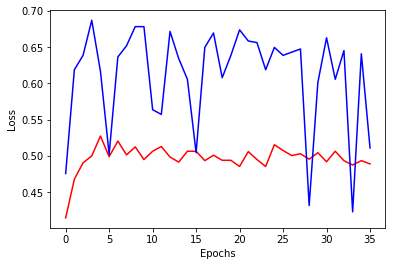

In [73]:
plt.plot(hist.history['acc'], color = 'red')
plt.plot(hist.history['val_acc'], color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()